In [2]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils.utils import *
from utils.dataset import *
from models.rnn_vae.encoder import Encoder
from models.rnn_vae.decoder import Decoder
from models.rnn_vae.predictor import Predictor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DATADIR = './data/gdb13/'
OUTDIR = './runs/run13.32/'
LOGFILE = os.path.join(OUTDIR, 'log.csv')
DATASPEC_FILE = os.path.join(DATADIR, 'spec.json')
RUNSPEC_FILE = os.path.join(OUTDIR, 'runspec.json')

dataspec = fetch_params(DATASPEC_FILE)
runspec = fetch_params(RUNSPEC_FILE)

## Data

In [4]:
trainset, testset = make_data(DATADIR, n=1000)

## Model

In [5]:
encoder = Encoder(runspec.L)
encoder.load_state_dict(torch.load(OUTDIR + 'encoder_weights.pth', map_location=torch.device('cpu')))

decoder = Decoder(runspec.L)
decoder.load_state_dict(torch.load(OUTDIR + 'decoder_weights.pth', map_location=torch.device('cpu')))

predictor = Predictor(runspec.L)
predictor.load_state_dict(torch.load(OUTDIR + 'predictor_weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
x, *_ = testset.sample(5)
z, *_ = encoder(x)
decoder(z, target=x).shape

torch.Size([5, 40, 21])

## Token Confidence

C1CCC(OC2=NC=CS2)OC1		C1CC2COC(CC3=C2C=NO3)O1
CNCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC		C1O111111111111111111111111111111111111
Euclidean Distance of Means: 15.534274101257324
Euclidean Distance of Samples: 15.49925422668457


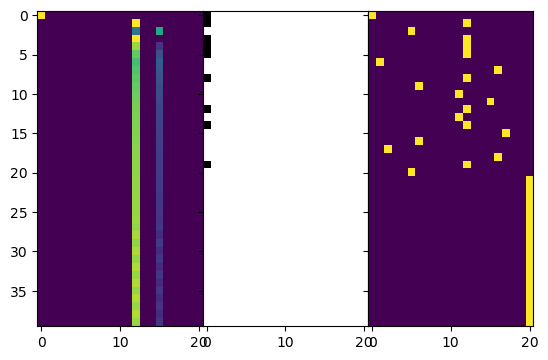

In [6]:
sample = testset.hots[random.sample(range(1, len(testset)), 2)]

s1, s2 = sample[0:1], sample[1:]

print(f'{from_hot(s1, dataspec.alphabet)[0]}\t\t{from_hot(s2, dataspec.alphabet)[0]}')

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

d1 = torch.argmax(s1, dim=2) != torch.argmax(s1_pred, dim=2)

print(f'{from_hot(s1_pred, dataspec.alphabet)[0]}\t\t{from_hot(s2_pred, dataspec.alphabet)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(d1.permute(1, 0).detach().numpy(), cmap='gray')
ax3.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

plt.subplots_adjust(wspace=0, hspace=0)

## Loss and Accuracy Plots

Text(0.5, 0, 'epoch')

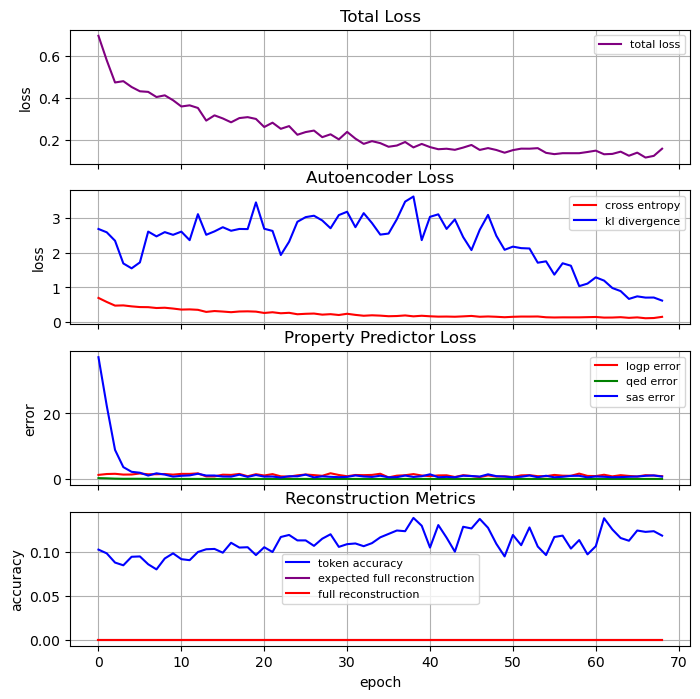

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv(LOGFILE)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(8, 8))

ax0.set_ylabel('loss')
ax0.set_title('Total Loss')
ax0.plot(log['loss'], color='purple', label='total loss')
ax0.grid()
ax0.legend(prop={'size': 8})

ax1.set_ylabel('loss')
ax1.set_title('Autoencoder Loss')
ax1.plot(log['ce'], color='red', label='cross entropy')
ax1.plot(log['kl'] * 0.1, color='blue', label='kl divergence')
ax1.grid()
ax1.legend(prop={'size': 8})

ax2.set_ylabel('error')
ax2.set_title('Property Predictor Loss')
ax2.plot(log['logp'], color='red', label='logp error')
ax2.plot(log['qed'], color='green', label='qed error')
ax2.plot(log['sas'], color='blue', label='sas error')
ax2.grid()
ax2.legend(prop={'size': 8})

ax3.set_ylabel('accuracy')
ax3.set_title('Reconstruction Metrics')
ax3.plot(log['accuracy'], color='blue', label='token accuracy')
ax3.plot(log['accuracy'] ** 40, color='purple', label='expected full reconstruction')
ax3.plot(log['prec'], color='red', label='full reconstruction')
ax3.grid()
ax3.legend(prop={'size': 8})
ax3.set_xlabel('epoch')